### In this notebook
1. Preprocessing the corpora of text (lemmatizing, keeping only nouns, filtering out meaningless terms, creating bigrams and trigrams, creating Bag-of-Words)
2. Tuning the hyperparameters of the LDA algorithm and modeling
3. Interpreting the results

## Getting started

### Importing necessary libraries

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models import TfidfModel
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

from itertools import chain

In [2]:
df = pd.read_csv('final.csv')['Text']

df[3]

"Catalans tend to be proud of their region's history, language and achievements, and it is no surprise that Catalan art is the focus of the Barcelona Design Museum. This newly opened institute brings together 70,000 pieces that were previously housed in four museums devoted to different aspects of the subject: textiles and fashion, graphics, ceramics and decorative arts. Read more by searching Homage to Catalonia via our website        "

## Preprocessing

### Lemmatizing and filtering by allowed POS-tags

Lemmatization is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form (e.g. from plural to singular ministers -> minister). 

Part-of-speech (POS) tagging is the process of categorizing words in a text (corpus) in correspondence with a particular part of speech, depending on the definition of the word and its context. In this way, we can decide which parts of speech to keep. After some tests, and as suggested by Martin and Johnson (2015), it turned out that keeping only nouns gives better results in terms of coherence scores.

In [3]:
def lemmatization(texts, allowed_postags = ['NOUN']):
    nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = ' '.join(new_text)
        texts_out.append(final)
    return (texts_out)

lemmatized_texts = lemmatization(df)
print(lemmatized_texts[3])

region history language achievement surprise art focus institute piece museum aspect subject textile fashion graphic ceramic art website


### Generating lists of words for each document

In [4]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc = True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print(data_words[3][0:20])

['region', 'history', 'language', 'achievement', 'surprise', 'art', 'focus', 'institute', 'piece', 'museum', 'aspect', 'subject', 'textile', 'fashion', 'graphic', 'ceramic', 'art', 'website']


### Filtering out meaningless words and terms shorter than 3 characters

In [5]:
lists = []
excluded_words = ['website', 'link', 'bio', 'photo', 'picture', 'illustration', 'tap', 'day', 
                  'image', 'year', 'week', 'month', 'credit', 'world', 'people', 'country',
                 'government', 'time', 'today', 'way', 'part', 'home', 'future', 'number',
                 'state', 'life', 'place', 'city', 'decade', 'group', 'pandemic', 'podcast',
                 'story', 'problem', 'plan', 'economist', 'region', 'capital', 'result',
                 'term', 'history', 'town', 'man', 'population', 'man', 'woman', 'hour',
                 'problem', 'end', 'view', 'medium', 'century', 'thing', 'one', 'datum']

for i in range(len(data_words)):
    lists.append([])

for i in range(len(data_words)):
    for token in data_words[i]:
        if len(token)>2 and token not in excluded_words:
            lists[i].append(token)

print(lists[3][0:20])

['language', 'achievement', 'surprise', 'art', 'focus', 'institute', 'piece', 'museum', 'aspect', 'subject', 'textile', 'fashion', 'graphic', 'ceramic', 'art']


### Creating bigrams and trigrams

N-gram is a sequence of N words. We will include 2-grams and 3-grams (bigrams and trigrams) to provide context to the analysis.

In [6]:
#Bigrams and trigrams

bigram_phrases = Phrases(lists, min_count = 3, threshold = 10)
trigram_phrases = Phrases(bigram_phrases[lists], threshold = 10)

bigram = Phraser(bigram_phrases)
trigram = Phraser(trigram_phrases)

def make_bigrams(texts):
     return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(lists)
data_bigrams_trigrams = make_trigrams(lists)

print(data_bigrams_trigrams[3])

['language', 'achievement', 'surprise', 'art', 'focus', 'institute', 'piece', 'museum', 'aspect', 'subject', 'textile', 'fashion', 'graphic', 'ceramic', 'art']


### Removing common words and creating BoW

Since we have manually removed the terms that could affect the quality of the obtained topics, we will not use the "automatic" removal technique (based on the percentage of corpus in which a term is present in the entire dataset). That's why the threshold (low-value) has been set to 0%.

Relying on a technique of this type is less demanding but can lead to the removal of terms that are useful to the topic modeling process. Depending on the case, by trial and error it is possible to understand which technique is more appropriate.

In [7]:
#TF-IDF removal

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word = id2word)

low_value = 0.00
words = []
words_missing_in_tfidf = []

for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    word_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow
    
print(corpus[0][0:20])

[(0, 1), (1, 1), (2, 1)]
[(0, 1), (1, 1), (2, 1)]


## Topic modeling using the LDA method

### Hyperparameters tuning

Mainly, the hyperparameters to be set are the number of topics, alpha (document-topic density) and eta (topic-word density). We will test which combination of k (number of topics), alpha and eta gives us the highest coherence score. Coherence is a measure we can use to evaluate the quality of the obtained topics, but we will also have to make sense of them and find a balance between coherence and human-interpretability.

Higher alpha -> more evenly distributed weight across topics

Higher eta -> topics are composed of fewer words

The best topics have been obtained setting eta = 0.2 and leaving alpha at its default value. Other combinations of these values gave higher coherence scores, but the quality of the obtained topics was poor in terms of interpretability.

In [65]:
n_topics = []
coherence = []
perplexity = []

for k in range(2,30):
    n_topics.append(k)
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = k,
                                           random_state = 100,
                                           chunksize = 3000,
                                           passes = 50,
                                           workers = 10,
                                           eta = 0.2)
    perplexity.append(lda_model.log_perplexity(corpus))
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_bigrams_trigrams, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence.append(coherence_lda)
    print('Number of topics: ' + str(k), 'Coherence: '+str(coherence_lda), 'Perplexity: ' + str(lda_model.log_perplexity(corpus)))
    
parameters = pd.DataFrame({'# topics':n_topics, 'Coherence':coherence, 'Perplexity':perplexity})
parameters

Number of topics: 2 Coherence: 0.1801940035731558 Perplexity: -8.423098338003715
Number of topics: 3 Coherence: 0.2593472708059506 Perplexity: -8.419974714873847
Number of topics: 4 Coherence: 0.3710684523340819 Perplexity: -8.429515238577332
Number of topics: 5 Coherence: 0.3817815701651504 Perplexity: -8.458753966020929
Number of topics: 6 Coherence: 0.385278454997486 Perplexity: -8.511038034010182
Number of topics: 7 Coherence: 0.3323678460317522 Perplexity: -8.536052492468453
Number of topics: 8 Coherence: 0.36876921287299225 Perplexity: -8.545500969376205
Number of topics: 9 Coherence: 0.3769552330267876 Perplexity: -8.556847391252536
Number of topics: 10 Coherence: 0.45082010450079374 Perplexity: -8.573973795058754
Number of topics: 11 Coherence: 0.3973996982797454 Perplexity: -8.601609617128206
Number of topics: 12 Coherence: 0.3880328453651311 Perplexity: -8.605675959609329
Number of topics: 13 Coherence: 0.38561063865381223 Perplexity: -8.637178759234102
Number of topics: 14 C

,# topics,Coherence,Perplexity
0,2,0.180194,-8.423098
1,3,0.259347,-8.419975
2,4,0.371068,-8.429509
3,5,0.381782,-8.458752
4,6,0.385278,-8.511032
5,7,0.332368,-8.536060
6,8,0.368769,-8.545476
7,9,0.376955,-8.556855
8,10,0.450820,-8.573984
9,11,0.397400,-8.601598


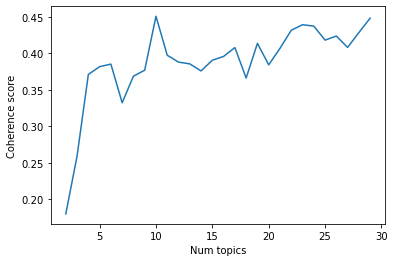

In [67]:
plt.plot(parameters['# topics'], parameters['Coherence'])
plt.xlabel('Num topics')
plt.ylabel('Coherence score')
plt.show()

We are getting 10 as the best number of topics to get the maximum coherence score before the curve starts decreasing. Other points of optimum can be identified and used, but the choice in this case is subjective and inherent to the degree of generalization we want to obtain for the individual topics. A higher number of topics can lead to more granular grouping, but also to a more difficult interpretation and a lower precision.

### Final LDA model

In [95]:
num_topics = 10

lda_model = gensim.models.ldamulticore.LdaMulticore(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = num_topics,
                                           random_state = 100,
                                           chunksize = 3000,
                                           passes = 50,
                                           workers = 10,
                                           eta = 0.2)

In [96]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds = 'mmds')
vis

/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in fav

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.233574  0.105762       1        1  17.337120
0      0.092505  0.214437       2        1  12.005567
3     -0.122316 -0.111507       3        1  11.673781
9     -0.179027  0.207976       4        1  11.067483
2      0.107001 -0.206186       5        1   9.590478
6     -0.070158  0.097638       6        1   8.983853
1     -0.047008 -0.201737       7        1   7.821020
4     -0.225607 -0.020556       8        1   7.629081
5      0.036961 -0.011400       9        1   6.964456
7      0.174077 -0.074426      10        1   6.927162, topic_info=            Term        Freq       Total Category  logprob  loglift
1087    election  640.000000  640.000000  Default  30.0000  30.0000
109    president  770.000000  770.000000  Default  29.0000  29.0000
436         firm  538.000000  538.000000  Default  28.0000  28.0000
3514       virus  334.000000  334.000000  Default  27.0000  27.0000
219      company  504.000000  504.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
9539    lockdown   49.797936  283.308104  Topic10  -5.5921   0.9312
219      company   52.922491  504.800123  Topic10  -5.5312   0.4144
567         food   42.371743  240.218778  Topic10  -5.7536   0.9347
304       crisis   41.584477  402.222217  Topic10  -5.7723   0.4004
223   investment   31.981483  127.324963  Topic10  -6.0349   1.2881

[665 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
7291      1  0.894807           abortion
7291     10  0.079893           abortion
4733      8  0.789404          accessory
1270      2  0.084900           accident
1270      6  0.806550           accident
...     ...       ...                ...
167       5  0.040202             worker
167       6  0.105144             worker
167       8  0.012370             worker
167      10  0.544277             worker
7840     10  0.682433  worker_bargaining

[2307 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 4, 10, 3, 7, 2, 5, 6, 8])

### Interpretation of the results

#### Creating wordclouds

In [97]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords = stop_words,
                 background_color = 'white',
                 width = 2500,
                 height = 2800,
                 max_words = 15,
                 colormap = 'tab10',
                 color_func = lambda *args, **kwargs: cols[i],
                 prefer_horizontal = 1.0)

topics = lda_model.show_topics(formatted = False, num_topics=num_topics)

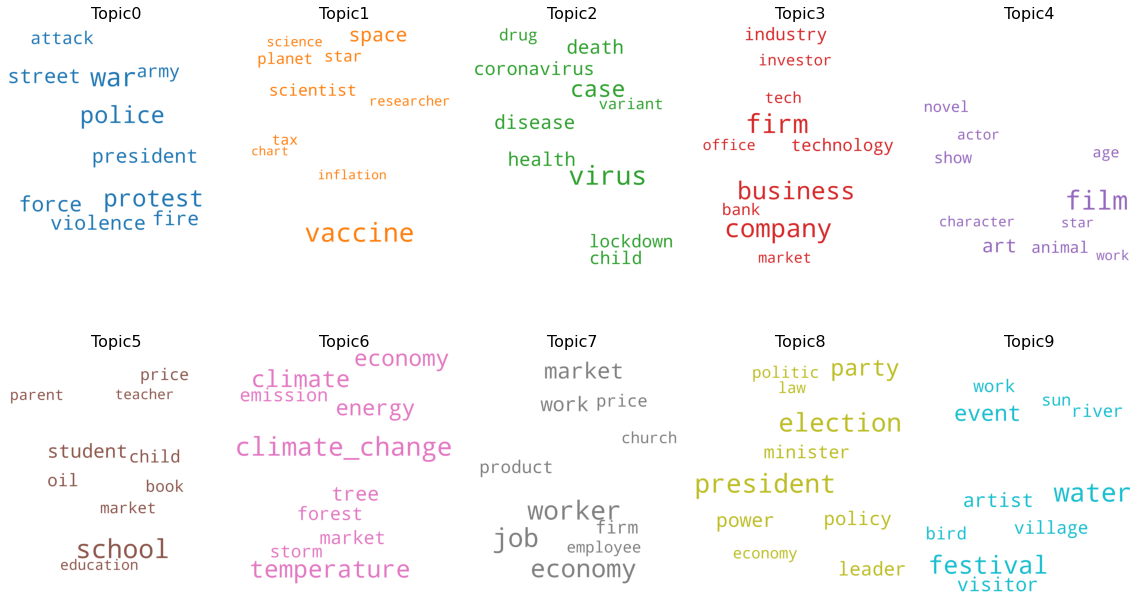

In [98]:
fig, axes = plt.subplots(2,5, figsize = (16, 10), sharex = True, sharey= True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size = 300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic' + str(i), fontdict = dict(size=16))
    plt.gca().axis('off')
    
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

This is the interpretation of the topics obtained through the lda algorithm:

0. News related to protests and conflicts
1. News related to scientific research (COVID-19 vaccine in particular)
2. News related to the COVID-19 pandemic
3. News related to business, financial markets and technology
4. News related to arts and entertainment
5. News related to school and education
6. News related to climate change, its causes and its consequences
7. News related to the economic situation and the labor market
8. News related to politics and elections
9. News related to festivals, exhibitions and celebrations

#### Assigning topic and probability to each post
In this way, we will be able to conduct further analysis (e.g. looking at the trending topics over time, exploring the relationship between topics and number of likes/comments, counting the number of posts per topic).

In [100]:
all_topics = lda_model.get_document_topics(corpus, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)
maxValueIndex = all_topics_df.idxmax(axis = 1)
maxValues = all_topics_df.max(axis = 1)

final = pd.read_csv('final.csv')
final['Topic'] = maxValueIndex
final['Probability'] = maxValues

final

,Datetime,Text,Likes,Comments,Lang,Length,Topic,Probability
0,2015-01-06 13:53:23,This Economist is from a story published in A...,102.0,1.0,en,217,4,0.460179
1,2015-01-06 18:14:26,How do members of the 114th Congress compare w...,111.0,6.0,en,281,8,0.819968
2,2015-01-07 17:20:59,This Economist is from a story in June 2013....,77.0,4.0,en,315,2,0.887399
3,2015-01-08 02:33:59,Catalans tend to be proud of their region's hi...,172.0,7.0,en,439,4,0.943718
4,2015-01-08 16:34:26,This Economist is from a story published in A...,71.0,6.0,en,347,2,0.581253
...,...,...,...,...,...,...,...,...
12209,2022-02-08 15:02:12,"On February 6th, more than a week after thousa...",3041.0,397.0,en,957,0,0.346139
12210,2022-02-08 17:02:09,Omicron is set to overtake Delta as the global...,5483.0,210.0,en,607,2,0.484215
12211,2022-02-08 19:02:55,British campaigners and lawmakers are in no do...,8456.0,228.0,en,739,3,0.618486
12212,2022-02-08 21:01:50,Every year Disney and its rivals promise to sp...,7434.0,71.0,en,655,7,0.550810


#### Distribution of probability

In [99]:
final['Probability'].describe()

count    12214.000000
mean         0.666757
std          0.186051
min          0.100000
25%          0.513533
50%          0.642885
75%          0.844997
max          0.985927
Name: Probability, dtype: float64

#### Number of posts per topic

In [101]:
final.groupby('Topic')['Text'].count()

Topic
0    1495
1     935
2    1040
3    1269
4     857
5     799
6    1087
7     730
8    2167
9    1835
Name: Text, dtype: int64

#### Average number of likes per topic

In [102]:
final.groupby('Topic')['Likes'].mean()

Topic
0     9346.171906
1     8340.407487
2    10303.789423
3     7824.382979
4     8749.439907
5     8002.714643
6     8907.392824
7     8503.265753
8     9431.496078
9     7450.282834
Name: Likes, dtype: float64